# Getting Started 

This tutorial covers the most basic use of `ott`:

- Compute the optimal transport between two point clouds using the Sinkhorn algorithm. 
- Use the seamless integration with `jax` to differentiate through this operation.

## Imports and toy data definition

`ott` is built on top of `jax`, so we use `jax` to define all the variables of the problem.

In [1]:
import jax
import jax.numpy as jnp

We also import `matplotlib` to plot the results.

In [2]:
import matplotlib.pyplot as plt

We define a toy function and use it to generate two datasets of points, `x` and `y`:

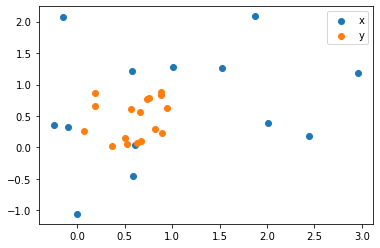

In [3]:
def create_points(rng, n_samples_x, n_samples_y, n_features):
    rngs = jax.random.split(rng, 3)
    x = jax.random.normal(rngs[0], (n_samples_x, n_features)) + 1
    y = jax.random.uniform(rngs[1], (n_samples_y, n_features))
    return x, y


rng = jax.random.PRNGKey(0)
n_samples_x, n_samples_y, n_features = 13, 17, 2
x, y = create_points(rng, n_samples_x, n_samples_y, n_features)

plt.scatter(x[:, 0], x[:, 1], label="x")
plt.scatter(y[:, 0], y[:, 1], label="y")
plt.legend()

## Optimal transport with OTT

We will now use `ott` to compute the optimal transport between `x` and `y`. To do so, we first create a `geometry` object that defines the geometry between the two point clouds:

In [4]:
from ott.geometry import pointcloud

geometry = pointcloud.PointCloud(x, y)

In order to compute the optimal transport corresponding to this `geometry`, we use the Sinkhorn algorithm:

In [5]:
from ott.solvers.linear import sinkhorn 

ot = sinkhorn.solve(geometry) 

As a small note: the computations here are *jitted*, meaning that the second time the solver is run it will be much faster:

In [6]:
ot = sinkhorn.solve(geometry) 

This object `ot` contains all the information about the solution of the optimal transport problems, including the transport plan matrix that indicates how much of the mass of the point `x[i]` is moved towards `y[j]`.

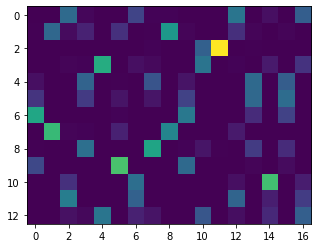

In [7]:
plt.imshow(ot.matrix)

## Seamless integration in JAX automatic differentiation pipelines

We finish this quick tour by illustration one of the most interesting feature of `ott`: most operations are differentiable, and it can be plugged easily into differentiable pipelines built in `jax`, like neural networks.

We demonstrate this by differentiating the primal loss of optimal transport with respect to the input dataset.

To do so, we simply define a function that takes `y` as input and outputs the loss:

In [8]:
def primal_cost_from_y(y):
    geometry = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geometry) 
    return ot.primal_cost


primal_cost_from_y(y)

DeviceArray(1.2848568, dtype=float32)

The gradient of this function is obtained as usual with `jax`:

In [9]:
gradient_function = jax.grad(primal_cost_from_y)
gradient_function(y)

DeviceArray([[-0.13677096, -0.12542462],
             [-0.17331457,  0.00316697],
             [ 0.00717247,  0.04084158],
             [-0.03964072, -0.07097346],
             [ 0.03364546, -0.01358469],
             [-0.23161316, -0.03622174],
             [ 0.02616614,  0.07189351],
             [-0.00402123, -0.07266501],
             [-0.17247105,  0.0015559 ],
             [-0.16569233, -0.09180653],
             [ 0.05348989, -0.01223391],
             [ 0.04273099, -0.14946938],
             [-0.03189152,  0.01724326],
             [-0.04778045, -0.05768591],
             [ 0.05030239,  0.12066668],
             [-0.06080055, -0.06514084],
             [ 0.04507273, -0.0108303 ]], dtype=float32)

For instance, this gradient can be used to update the dataset `y` to make it go towards `x`:

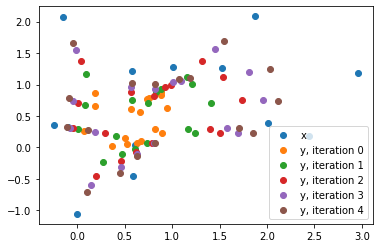

In [10]:
step_size = 2.

plt.scatter(x[:, 0], x[:, 1], label="x")
for i in range(5):
    plt.scatter(y[:, 0], y[:, 1], label=f"y, iteration {i}")
    y -= step_size * gradient_function(y)
plt.legend()